### Project Description

One of the questions I will explore in this project is how the density profile changes before and after the MW-M31 merger, and how much each of the haloes contribute to the final density profile.

To do so, I will plot the density profiles of the halo particles of MW and M31 before and after merger, as well as the total density profile after merger. Depending on initial discoveries from these plots, I will make further diagnostic plots to emphasize interesting findings.

In [1]:
# import modules
from os.path import join
import numpy as np
import astropy.units as u
from astropy.constants import G
import scipy.optimize as so
from colossus.cosmology import cosmology
from IPython.display import Latex

# import plotting modules
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

# my modules
from HaloEnergetics import HaloEnergetics

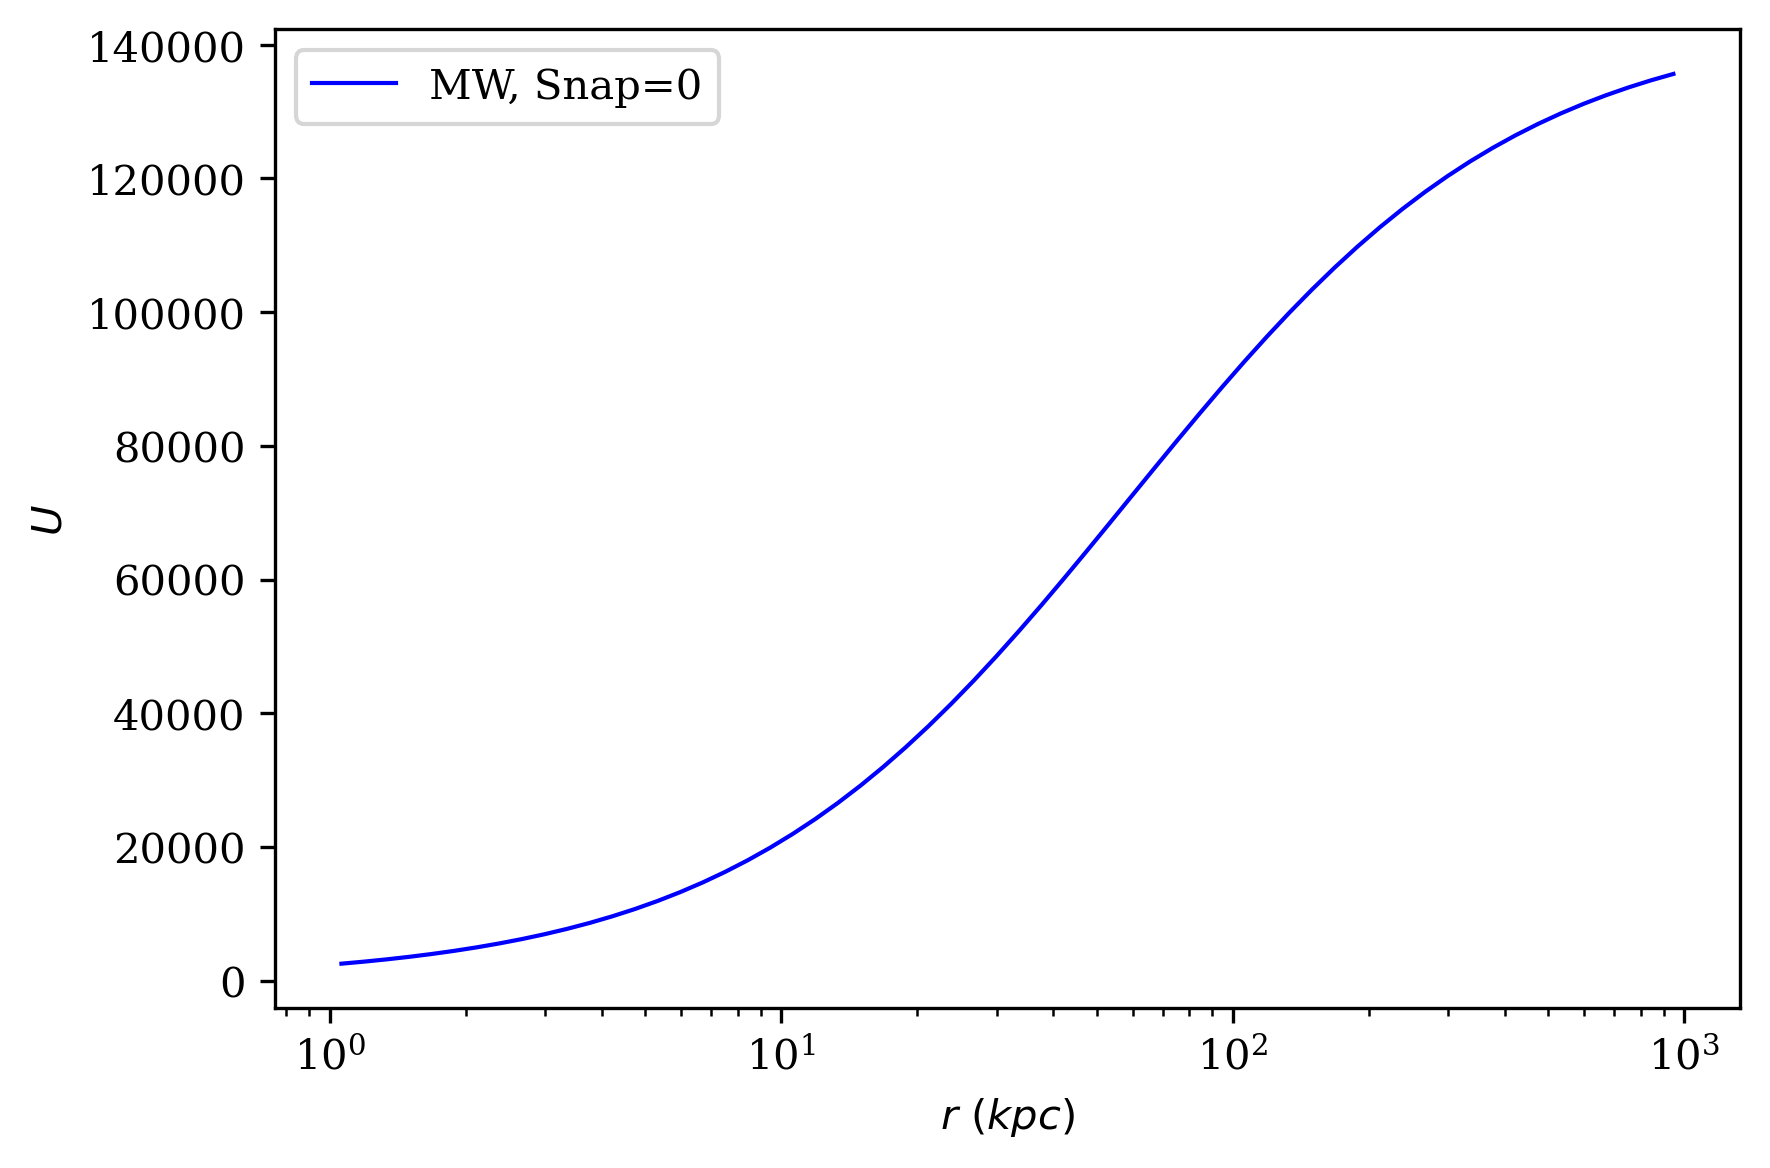

In [7]:
# Plot density profiles of MW and M31 halo particles, as well as total
plt.rcParams.update({"font.family": "serif", "figure.dpi": 300})
plt.semilogx(MW_0.r, MW_0.U, color='blue', lw=1, label='MW, Snap=0')
plt.xlabel(r'$r$ $(kpc)$')
plt.ylabel(r'$U$')
plt.legend()
plt.tight_layout()
plt.show()

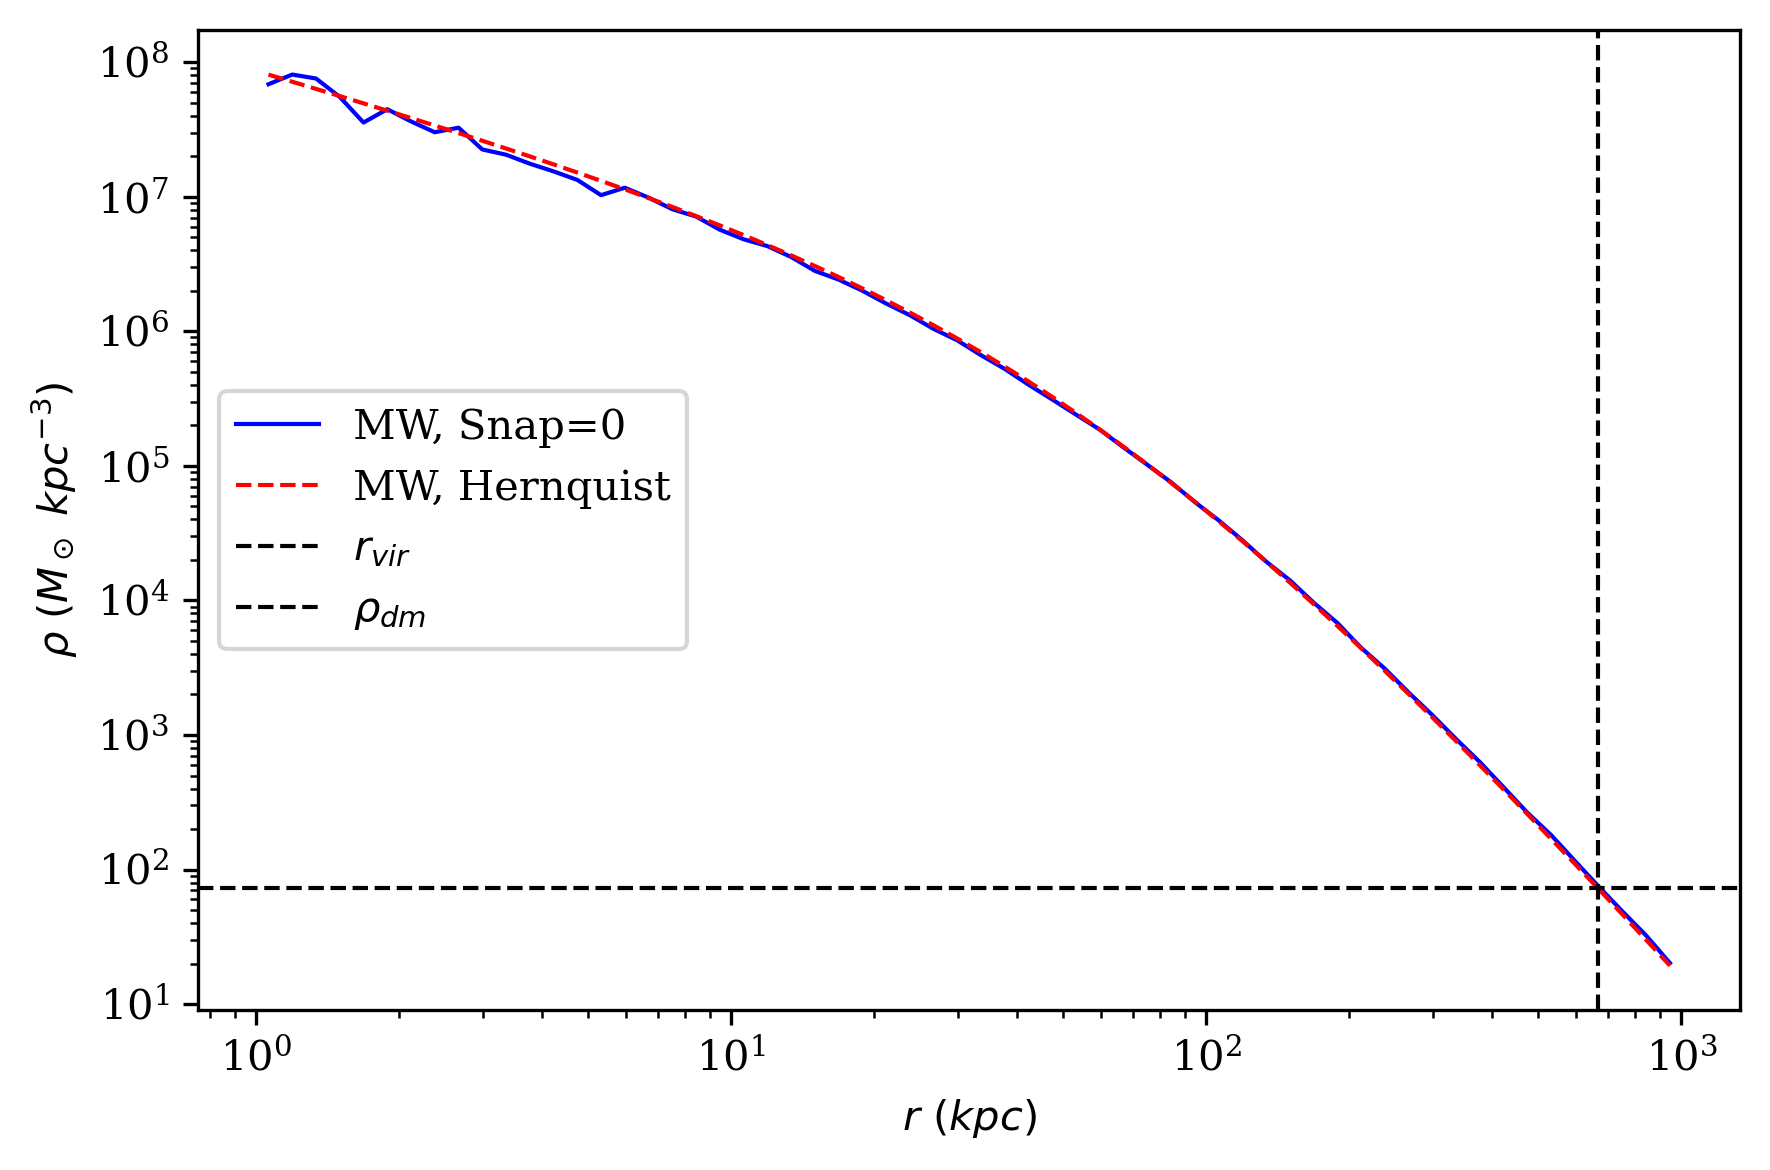

In [11]:
# Plot density profiles of MW and M31 halo particles, as well as total
plt.rcParams.update({"font.family": "serif", "figure.dpi": 300})
plt.loglog(MW_0.r, MW_0.rho, color='blue', lw=1, label='MW, Snap=0')
plt.loglog(MW_0.r, MW_0.hernquist(MW_0.r, MW_0.M, MW_0.a), color='red', linestyle='--', lw=1, label='MW, Hernquist')
plt.axvline(MW_0.r_vir, color='k', lw=1, linestyle='--', label=r'$r_{vir}$')
plt.axhline(rho_dm, color='k', lw=1, linestyle='--', label=r'$\rho_{dm}$')
plt.xlabel(r'$r$ $(kpc)$')
plt.ylabel(r'$\rho$ $(M_\odot~kpc^{-3})$')
plt.legend()
plt.tight_layout()
plt.show()

The equation I'm using for the density profile given the enclose mass profile is:

$$\rho_i = \frac{M_{enc, i+1} - M_{enc, i}}{V_{enc, i+1} - V_{enc, i}}$$

where $\rho$ are the densities, $M_{enc}$ are enclosed masses, $V_{enc}$ are the enclosed volumes. The radii for $\rho_i$ is:

$$r_i = \frac{R_{i+1} + R_i}{2}$$

where $R$ are the radii for the enclosed mass profile.

In [ ]:

r_enc = np.logspace(0, 3, 61)

In [ ]:
MW_800 = HaloEnergetics('MW', 800)

In [3]:
# Initialize MassProfile objects for MW and M31 after merger
MP_MW_end = MassProfile('MW', 800)
MP_M31_end = MassProfile('M31', 800)

In [10]:
# Compute density profiles
r, rho_MW = halo_density_profile(MP_MW_end, r_enc)
_, rho_M31 = halo_density_profile(MP_M31_end, r_enc)
rho_tot = rho_MW + rho_M31
np.save('data/rho_MW_800', np.vstack((r, rho_MW)))
np.save('data/rho_M31_800', np.vstack((r, rho_M31)))
np.save('data/rho_tot_800', np.vstack((r, rho_tot)))

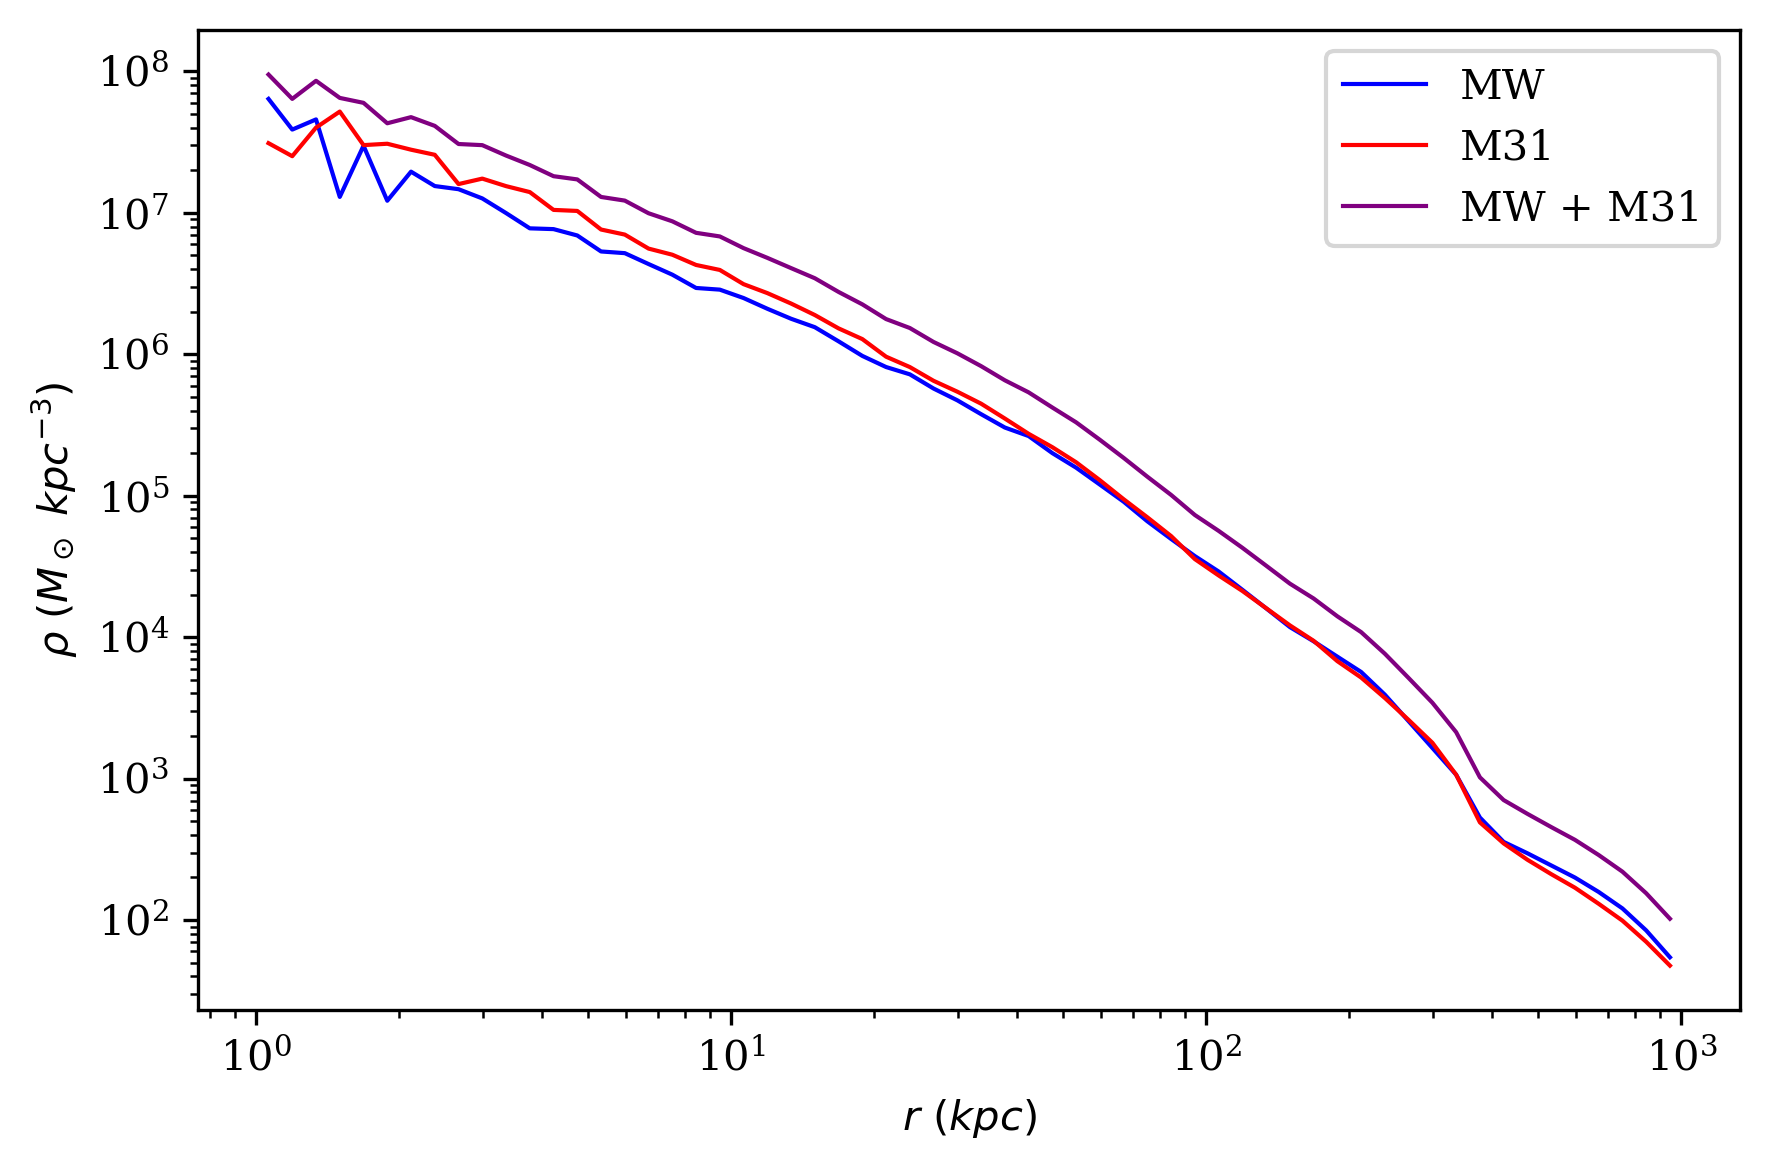

In [7]:
# Plot density profiles of MW and M31 halo particles, as well as total
plt.rcParams.update({"font.family": "serif", "figure.dpi": 300})
plt.loglog(r, rho_MW, color='blue', lw=1, label='MW')
plt.loglog(r, rho_M31, color='red', lw=1, label='M31')
plt.loglog(r, rho_tot, color='purple', lw=1, label='MW + M31')
plt.xlabel(r'$r$ $(kpc)$')
plt.ylabel(r'$\rho$ $(M_\odot~kpc^{-3})$')
plt.legend()
plt.tight_layout()
plt.show()

Interestingly, M31 particles seem to dominate slightly on the inner region of the halo, while MW particles edge out ever so slightly on the outer region. I will now make a plot of $\frac{\rho_{M31}-\rho_{MW}}{\rho_{M31}}$ to attempt to highlight this difference.

In [13]:
rho_M31_MW = rho_M31 - rho_MW
f_M31_MW = rho_M31_MW / rho_M31
np.save('data/f_M31_MW_800', np.vstack((r, f_M31_MW)))

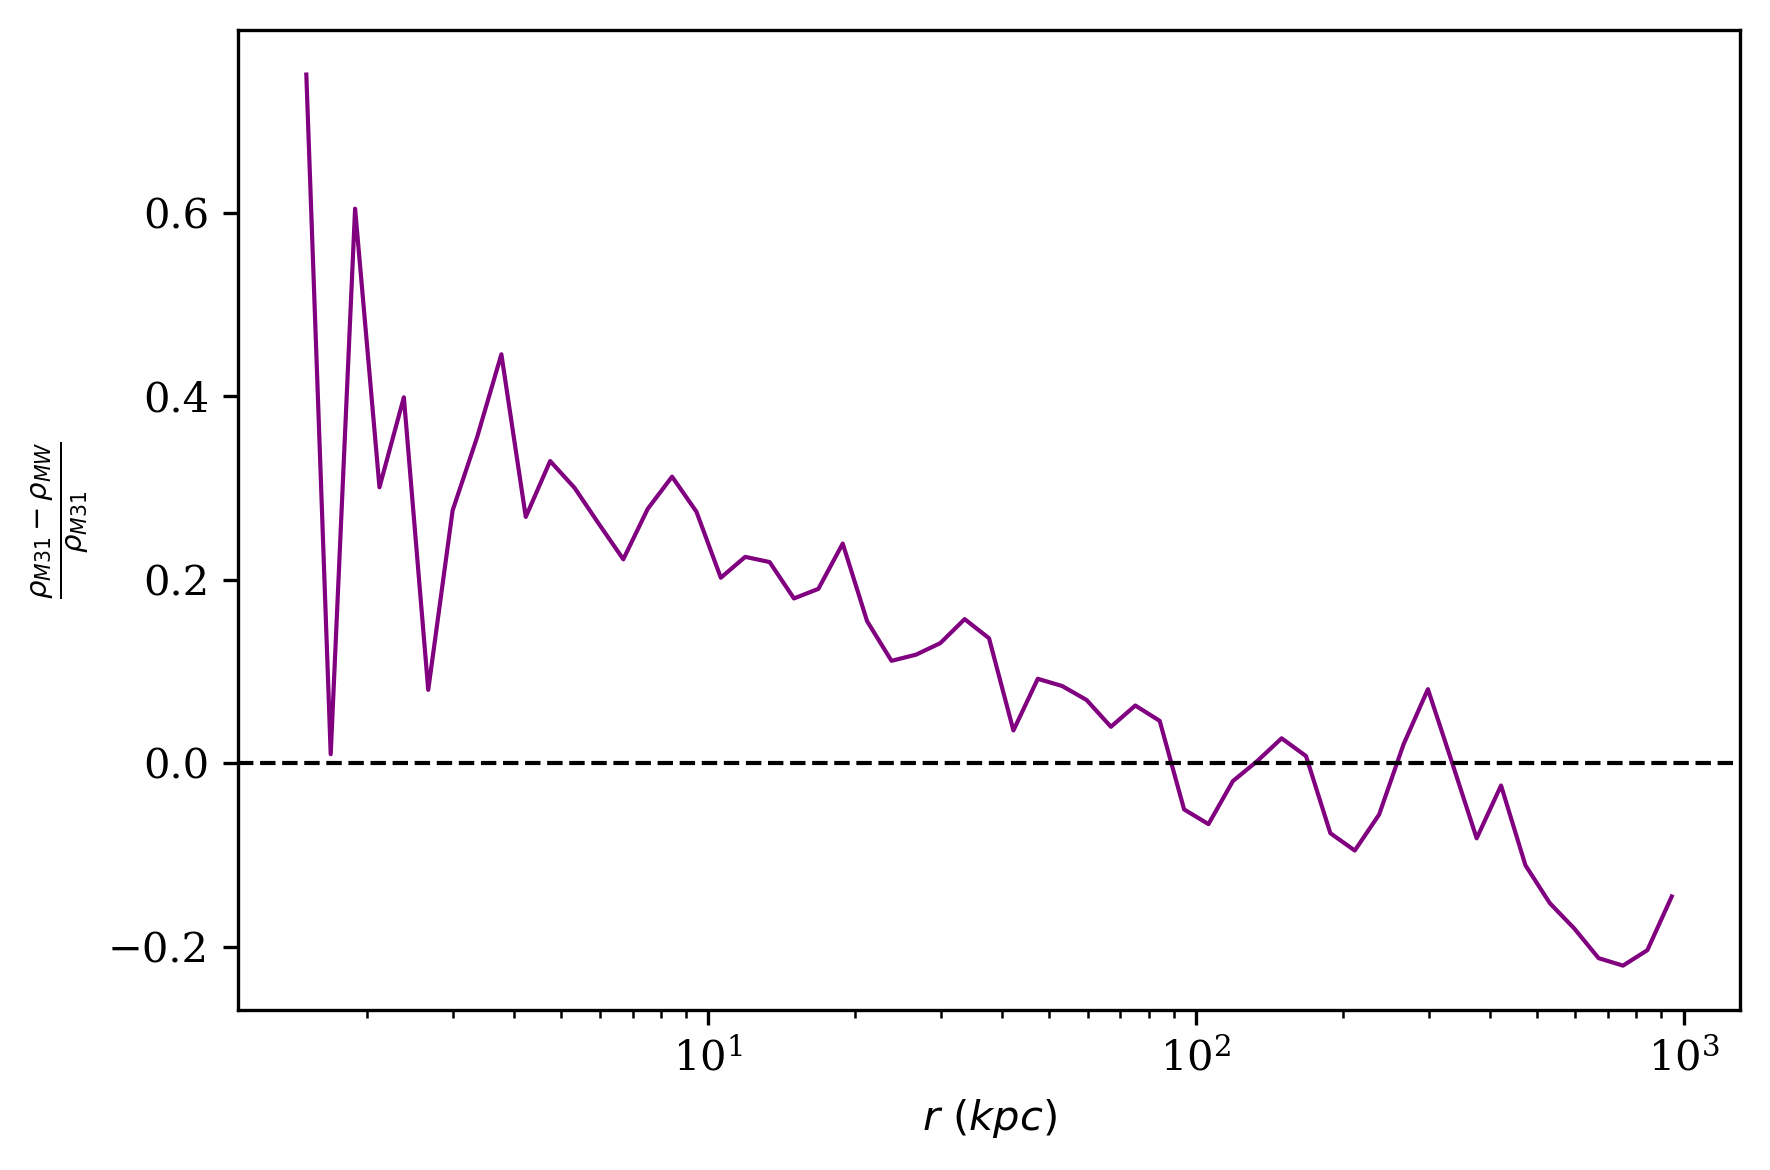

In [15]:
# Plot density difference between M31 and MW
plt.rcParams.update({"font.family": "serif", "figure.dpi": 300})
plt.plot(r[3:], f_M31_MW[3:], color='purple', lw=1)
plt.axhline(0, ls='--', lw=1, color='black')
plt.xscale('log')
plt.xlabel(r'$r$ $(kpc)$')
plt.ylabel(r'$\frac{\rho_{M31}-\rho_{MW}}{\rho_{M31}}$')
plt.tight_layout()
plt.show()

From this we can see that M31 halo contributes more to the inner part of the merger profile, while MW contributes slightly more to the outer. Now I want to explore how exactly this came about. I will now plot the halo density profiles of MW and M31 before merger.

In [14]:
# Initialize MassProfile objects for MW and M31 before merger
MP_MW_start = MassProfile('MW', 0)
MP_M31_start = MassProfile('M31', 0)

In [15]:
# Compute density profiles
r_enc = np.logspace(0, 3, 61)
r, rho_MW = halo_density_profile(MP_MW_start, r_enc)
_, rho_M31 = halo_density_profile(MP_M31_start, r_enc)
rho_tot = rho_MW + rho_M31
np.save('data/rho_MW_0', np.vstack((r, rho_MW)))
np.save('data/rho_M31_0', np.vstack((r, rho_M31)))
np.save('data/rho_tot_0', np.vstack((r, rho_tot)))

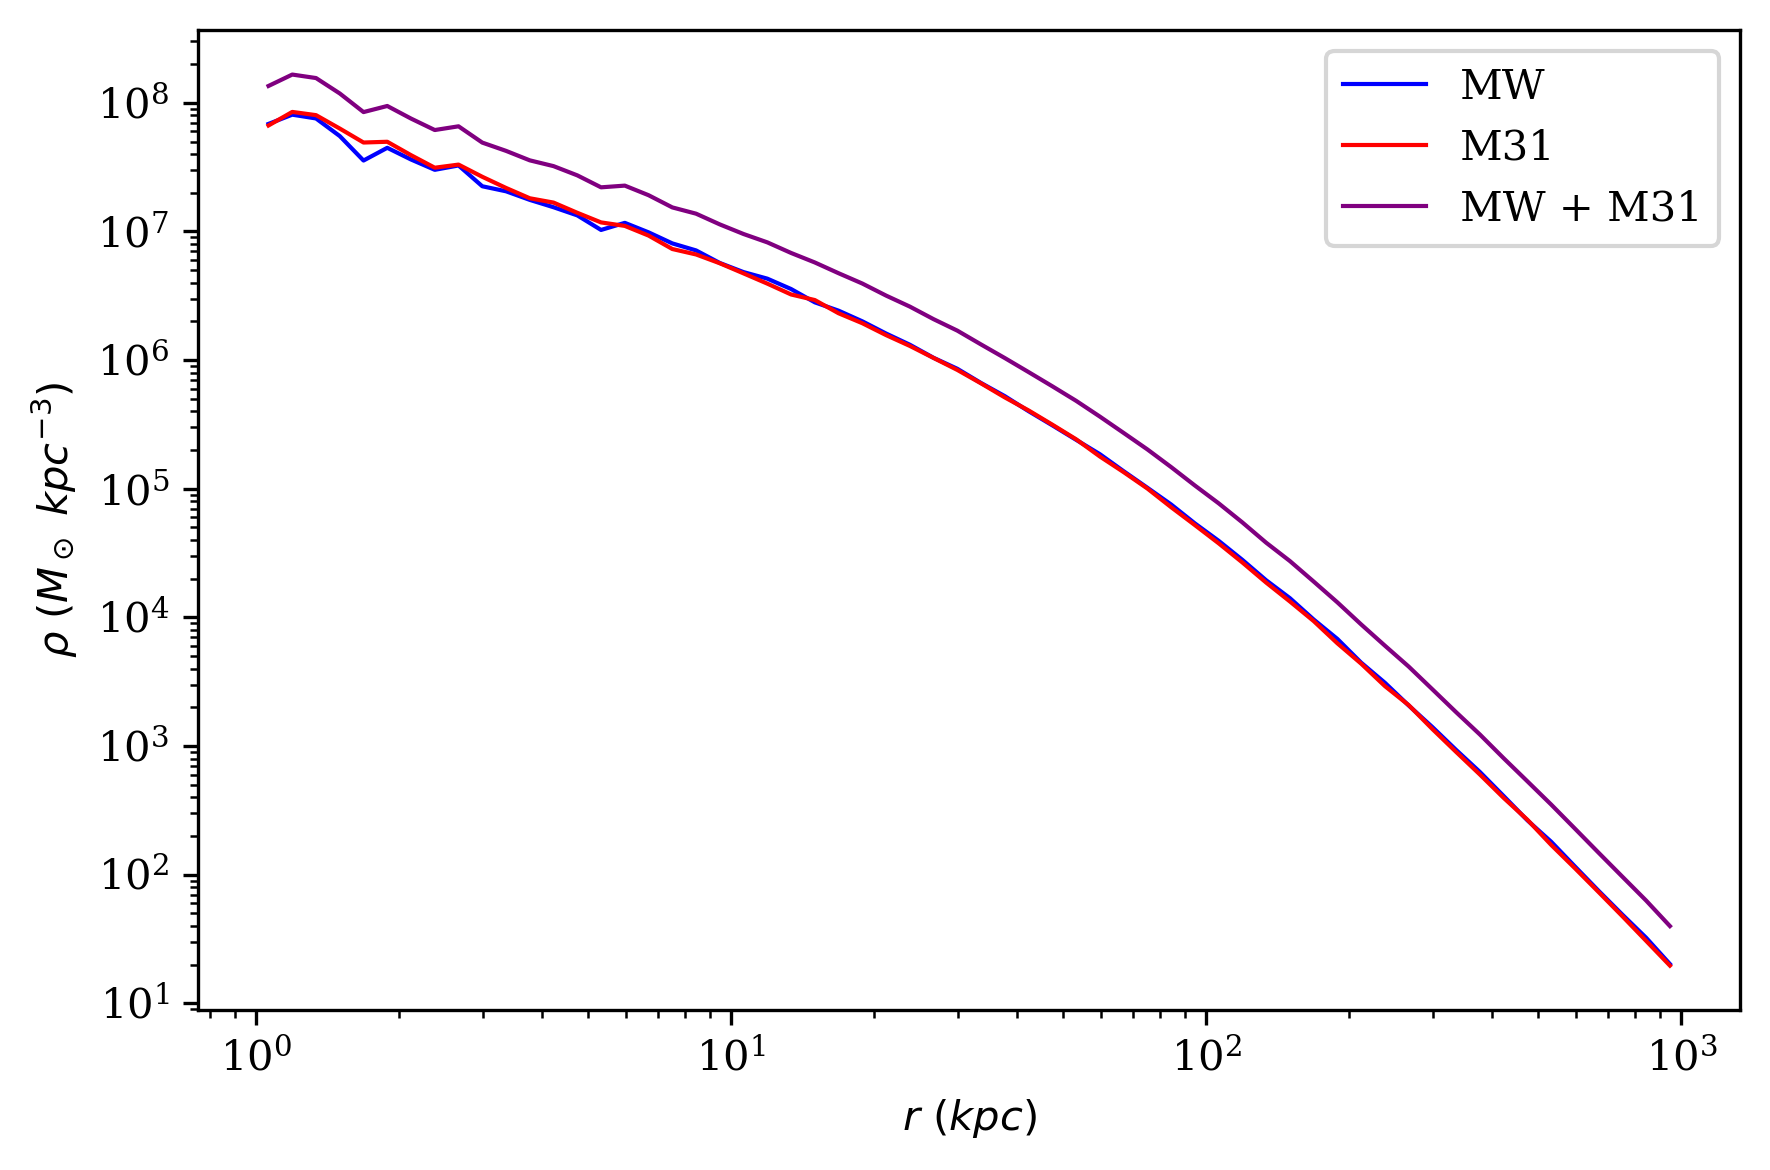

In [5]:
# Plot density profiles of MW and M31 halo particles, as well as total
plt.rcParams.update({"font.family": "serif", "figure.dpi": 300})
plt.loglog(r, rho_MW, color='blue', lw=1, label='MW')
plt.loglog(r, rho_M31, color='red', lw=1, label='M31')
plt.loglog(r, rho_tot, color='purple', lw=1, label='MW + M31')
plt.xlabel(r'$r$ $(kpc)$')
plt.ylabel(r'$\rho$ $(M_\odot~kpc^{-3})$')
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
rho_M31_MW = rho_M31 - rho_MW
f_M31_MW = rho_M31_MW / rho_M31
np.save('data/f_M31_MW_0', np.vstack((r, f_M31_MW)))

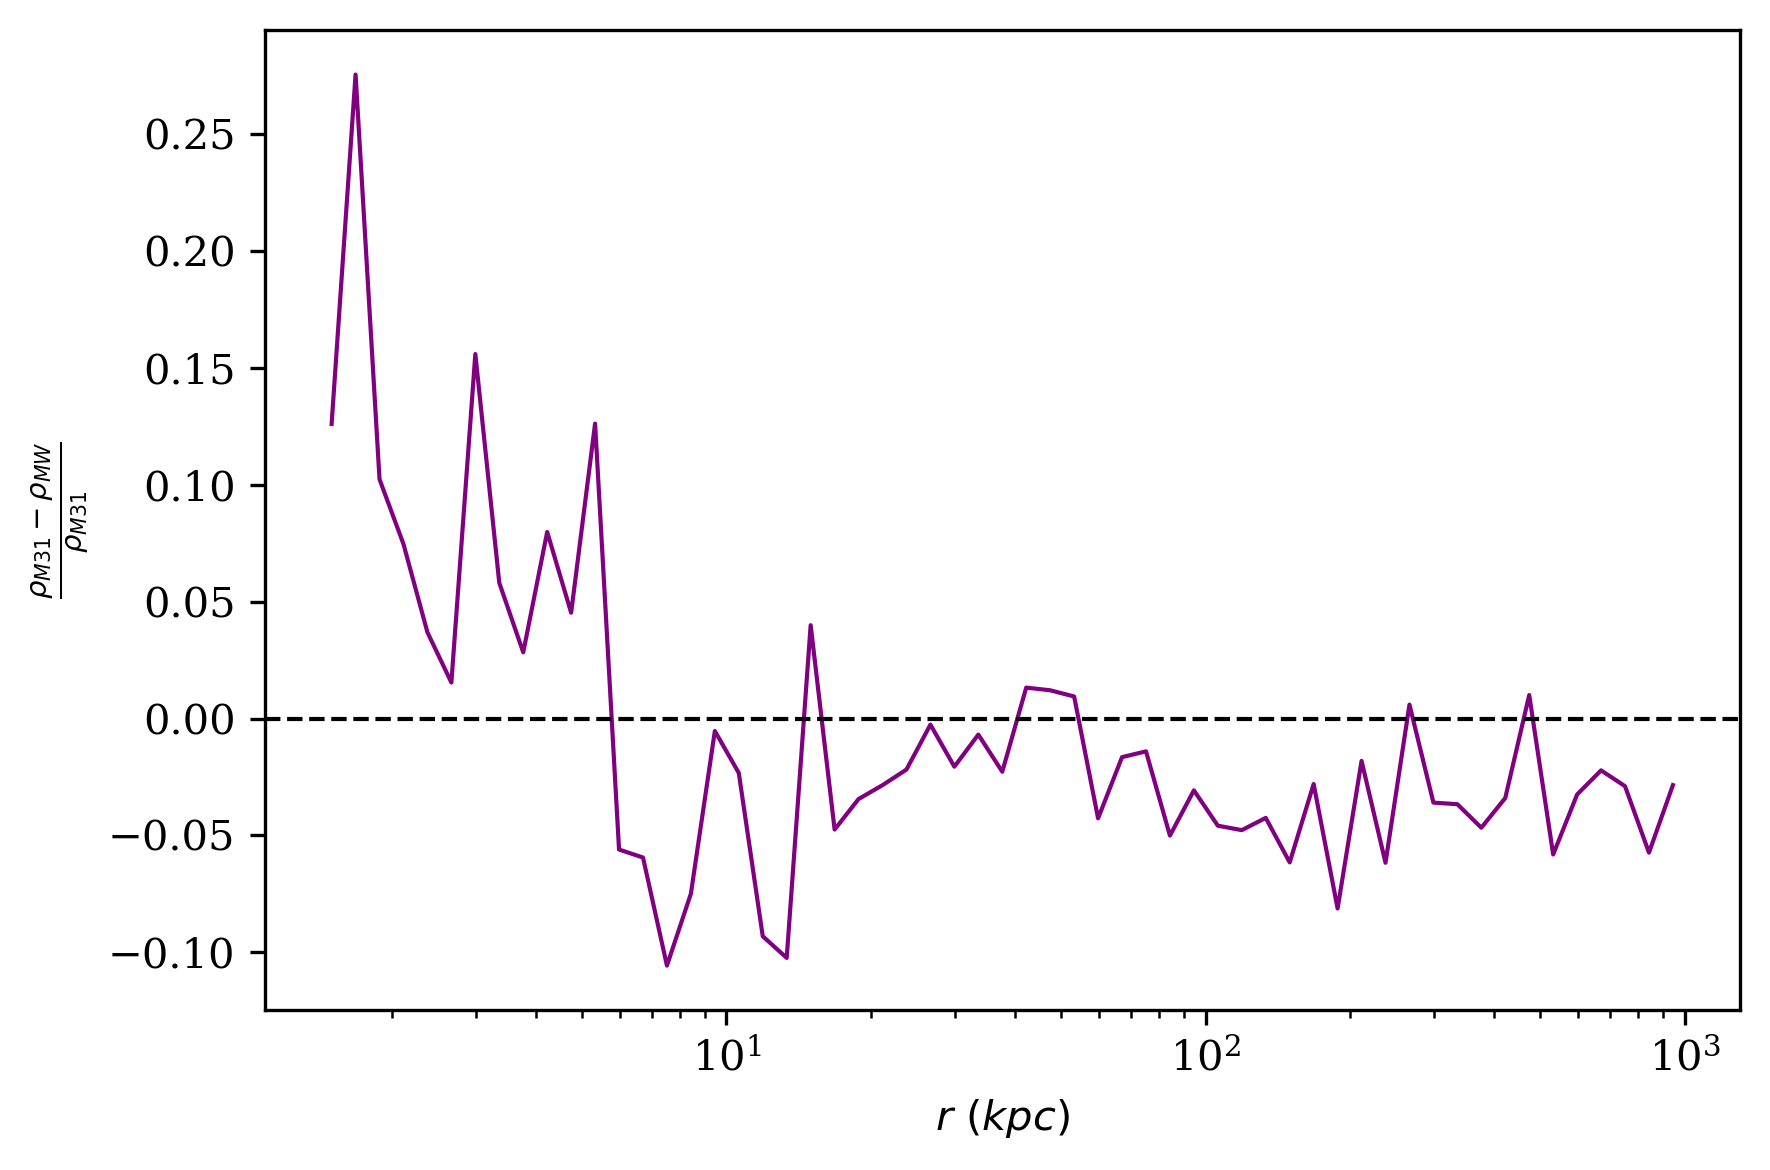

In [7]:
# Plot density difference between M31 and MW
plt.rcParams.update({"font.family": "serif", "figure.dpi": 300})
plt.plot(r[3:], f_M31_MW[3:], color='purple', lw=1)
plt.axhline(0, ls='--', lw=1, color='black')
plt.xscale('log')
plt.xlabel(r'$r$ $(kpc)$')
plt.ylabel(r'$\frac{\rho_{M31}-\rho_{MW}}{\rho_{M31}}$')
plt.tight_layout()
plt.show()

In [17]:
f_0 = np.load('data/f_M31_MW_0.npy')[1]
f_800 = np.load('data/f_M31_MW_800.npy')[1]

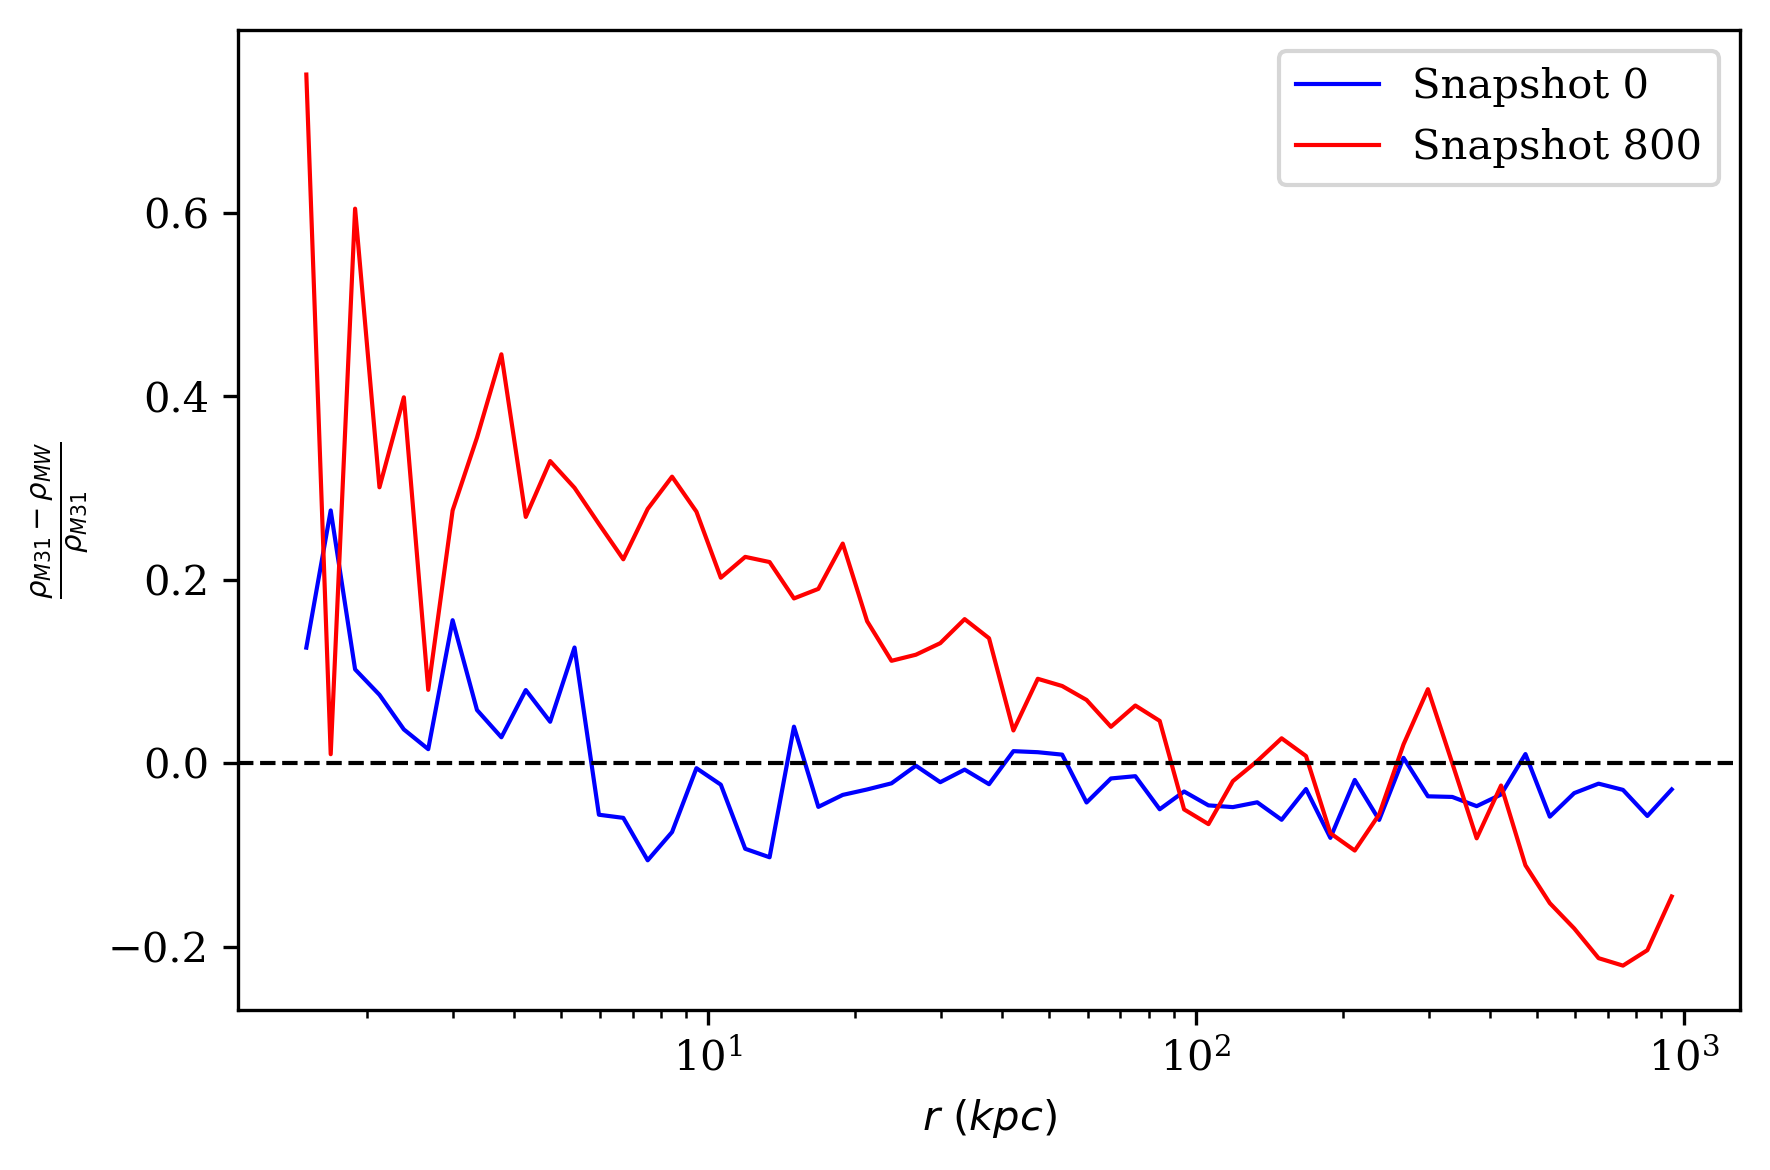

In [18]:
# Compare density difference for snapshot 0 and 800
plt.rcParams.update({"font.family": "serif", "figure.dpi": 300})
plt.plot(r[3:], f_0[3:], color='blue', lw=1, label='Snapshot 0')
plt.plot(r[3:], f_800[3:], color='red', lw=1, label='Snapshot 800')
plt.axhline(0, ls='--', lw=1, color='black')
plt.xscale('log')
plt.xlabel(r'$r$ $(kpc)$')
plt.ylabel(r'$\frac{\rho_{M31}-\rho_{MW}}{\rho_{M31}}$')
plt.legend()
plt.tight_layout()
plt.show()

In the beginning, halo profiles of MW and M31 look nearly the same. This suggests that the discrepancy we see in the merger density profile is due to either stellar mass distributions or initial kinematics.

Now I will fit the NFW profiles to each of the haloes before and after merger.

In [38]:
def Hernquist(r, M, a):
    '''
    Computes the Hernquist density profile at a single point or an array of radii.
    
    Arguments:
    r: float or np.array, radii at which density will be computed
    rho_0: float, central density
    '''
    return (M/(2*np.pi)) * a/(r*(r+a)**3)

In [25]:
rho_MW_0 = np.load('data/rho_MW_0.npy')[1]

In [56]:
popt, pconv = so.curve_fit(Hernquist, r, rho_MW_0, bounds=([1.974999e12, 1], [1.975001e12, 200]), method='trf')

In [58]:
a = popt[1]
M = popt[0]

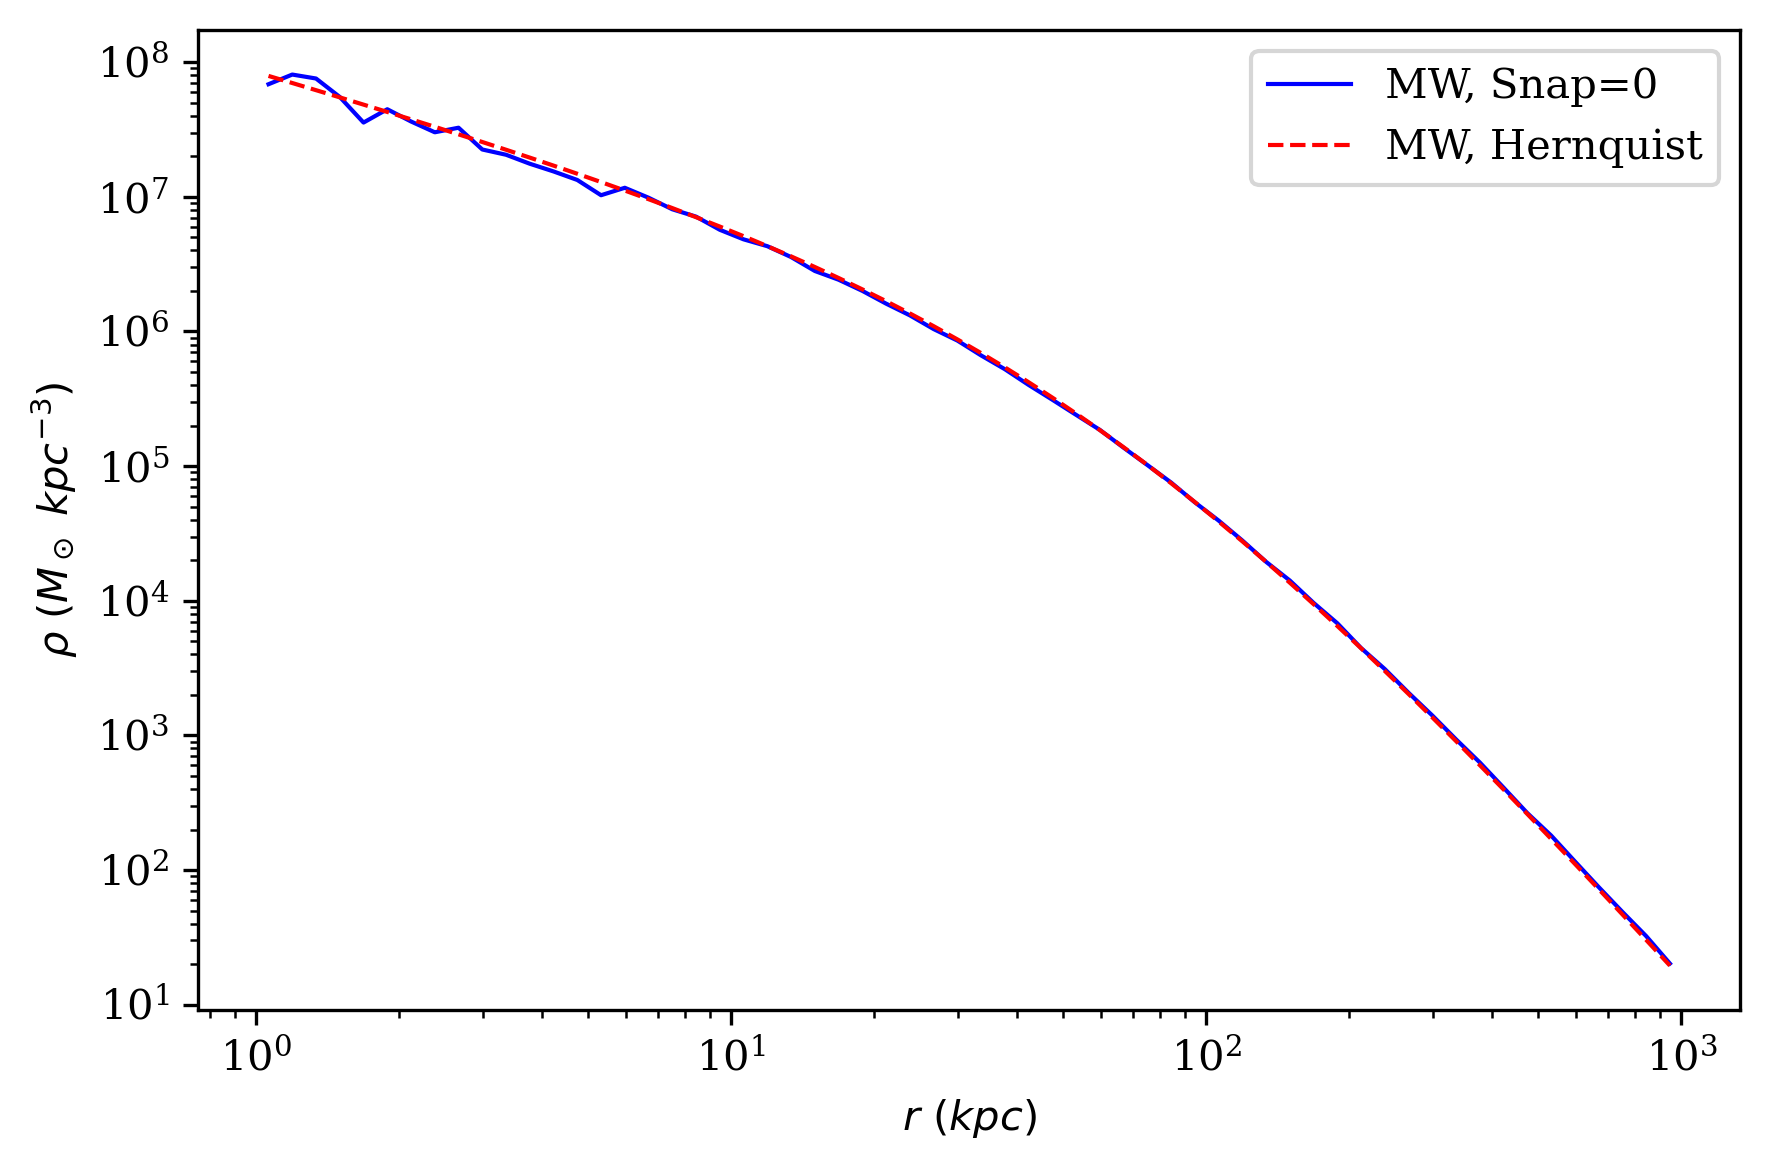

In [59]:
# Plot density profiles of MW and M31 halo particles, as well as total
plt.rcParams.update({"font.family": "serif", "figure.dpi": 300})
plt.loglog(r, rho_MW, color='blue', lw=1, label='MW, Snap=0')
plt.loglog(r, Hernquist(r, M, a), color='red', linestyle='--', lw=1, label='MW, Hernquist')
plt.xlabel(r'$r$ $(kpc)$')
plt.ylabel(r'$\rho$ $(M_\odot~kpc^{-3})$')
plt.legend()
plt.tight_layout()
plt.show()